In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans, AgglomerativeClustering, OPTICS, DBSCAN, cluster_optics_dbscan
from sklearn_extra.cluster import KMedoids
import random
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import euclidean
from sklearn.base import clone
import yfinance as yf
from utils.utils import Portfolio
from utils.helpers import pooled_within_ssd, gen_realizations, gap_statistic, cluster_range, plot_internal, plot_internal_zoom_range
from utils.clusters import kmeans_cluster, kmedoids_cluster, agglomerative_cluster

### Load Data from YF for S&P500 and save it

In [3]:
sp500 = Portfolio('2013-01-01', '2024-01-01')
sp500_train = Portfolio('2013-01-01', '2023-01-01')
sp500_test = Portfolio('2023-01-01', '2024-01-01')
dji_test = Portfolio('2023-01-01','2024-01-01', file = 'data/dji.csv')

## Baselines for Sharpe Ratio: DJI & 30 Random

In [4]:
baseline = dji_test.metrics.copy()
baseline.loc['SP500'] = [sp500_test.get_portf_sharpe(), sp500_test.get_portf_sortino(), sp500_test.get_portf_return(), sp500_test.get_portf_volatility()]
baseline

,Sharpe,Sortino,Returns,Volatility
DJI,0.071854,0.116324,0.137407,0.007196
SP500,0.096611,0.150627,0.228182,0.008544


In [5]:
random_sharpe = []
random_sortino = []
random_return = []
random_volatility  = []
for i in range(1000):
    rand_stocks = random.sample(list(sp500_train.stock_sharpe.index), 30)
    random_sharpe.append(sp500_test.get_portf_sharpe(tick = rand_stocks))
    random_sortino.append(sp500_test.get_portf_sortino(tick = rand_stocks))
    random_return.append(sp500_test.get_portf_return(tick = rand_stocks))
    random_volatility.append(sp500_test.get_portf_volatility(tick = rand_stocks))
baseline.loc['Random'] = [np.array(random_sharpe).mean(), np.array(random_sortino).mean(), np.array(random_return).mean(), np.array(random_volatility).mean()]
baseline

,Sharpe,Sortino,Returns,Volatility
DJI,0.071854,0.116324,0.137407,0.007196
SP500,0.096611,0.150627,0.228182,0.008544
Random,0.082267,0.131013,0.215656,0.009320


In [6]:
top30 = list(sp500_train.stock_sharpe.sort_values(by = 'Sharpe', ascending = False).iloc[:30].index)
baseline.loc['Top30'] = [sp500_test.get_portf_sharpe(tick = top30), 
                         sp500_test.get_portf_sortino(tick = top30), 
                         sp500_test.get_portf_return(tick = top30),
                         sp500_test.get_portf_volatility(tick = top30)]
baseline

,Sharpe,Sortino,Returns,Volatility
DJI,0.071854,0.116324,0.137407,0.007196
SP500,0.096611,0.150627,0.228182,0.008544
Random,0.082267,0.131013,0.215656,0.009320
Top30,0.122589,0.190844,0.264911,0.007699


In [7]:
from scipy.stats import ttest_1samp

benchmark = dji_test.get_portf_sharpe()

# Perform one-sample t-test
t_statistic, p_value = ttest_1samp(np.array(random_sharpe), benchmark)

# Since ttest_1samp performs a two-tailed test, we need to adjust p-value for one-tailed test
p_value_one_tailed = p_value / 2 if t_statistic > 0 else 1 - (p_value / 2)

print(f"T-Statistic: {t_statistic}")
print(f"P-Value (one-tailed): {p_value_one_tailed}")

T-Statistic: 11.317977616183926
P-Value (one-tailed): 2.5019516284333256e-28


To set the baselines, we are using the Dow Jones Index which is a stock market index that measures the stock performance of 30 prominent companies listed on stock exchanges in the United States. We also used the average of a 30-trial Monte Carlo Simulation of 30 random stock portfolios.

## Preprocessing

### Scale Data: Standardization

In [8]:
standard_scaler = StandardScaler()
X_unscaled = sp500_train.daily_log_returns.T.copy()
X_scaled = standard_scaler.fit_transform(X_unscaled)

## Representative-Based Clustering (RBC): KMeans & KMedoids

### KMeans for 30 Clusters
For comparison to the DJI, we set our preset our cluster to 30 and pick the best performing stock in each cluster based on Sharpe ratio from 2013 to 2023. Each clsuter is supposed to represent differing levels of returns. We are diversifying our portfolio by taking one from each.



##### Unscaled

In [9]:
results = kmeans_cluster(sp500_train.daily_log_returns, sp500_train.stock_sharpe, sp500_test)
results['volatility'] = Portfolio(sp500_test.start_date, sp500_test.end_date, tickers=results['portfolio']).get_portf_volatility()
baseline.loc['Kmeans_30_unscaled'] = [results[i] for i in ['sharpe', 'sortino', 'return', 'volatility']]
baseline

Clustering Type        : KMeans
Clusters (preset)      : 30
Portfolio Sharpe Ratio : 0.1184
Silhouette Score       : 0.0124
Davies-Bouldin         : 2.0423
Calinski Harabasz      : 7.8026


,Sharpe,Sortino,Returns,Volatility
DJI,0.071854,0.116324,0.137407,0.007196
SP500,0.096611,0.150627,0.228182,0.008544
Random,0.082267,0.131013,0.215656,0.009320
Top30,0.122589,0.190844,0.264911,0.007699
Kmeans_30_unscaled,0.118351,0.175163,0.388573,0.011140


In [10]:
results = kmeans_cluster(sp500_train.daily_log_returns, sp500_train.stock_sharpe, sp500_test, scale=True)
results['volatility'] = Portfolio(sp500_test.start_date, sp500_test.end_date, tickers=results['portfolio']).get_portf_volatility()
baseline.loc['Kmeans_30_scaled'] = [results[i] for i in ['sharpe', 'sortino', 'return', 'volatility']]
baseline

Clustering Type        : KMeans
Clusters (preset)      : 30
Portfolio Sharpe Ratio : 0.1103
Silhouette Score       : 0.0145
Davies-Bouldin         : 2.2245
Calinski Harabasz      : 6.9467


,Sharpe,Sortino,Returns,Volatility
DJI,0.071854,0.116324,0.137407,0.007196
SP500,0.096611,0.150627,0.228182,0.008544
Random,0.082267,0.131013,0.215656,0.009320
Top30,0.122589,0.190844,0.264911,0.007699
Kmeans_30_unscaled,0.118351,0.175163,0.388573,0.011140
Kmeans_30_scaled,0.110255,0.160551,0.336451,0.010564


### KMeans: Find optimal k-clusters

#### Unscaled

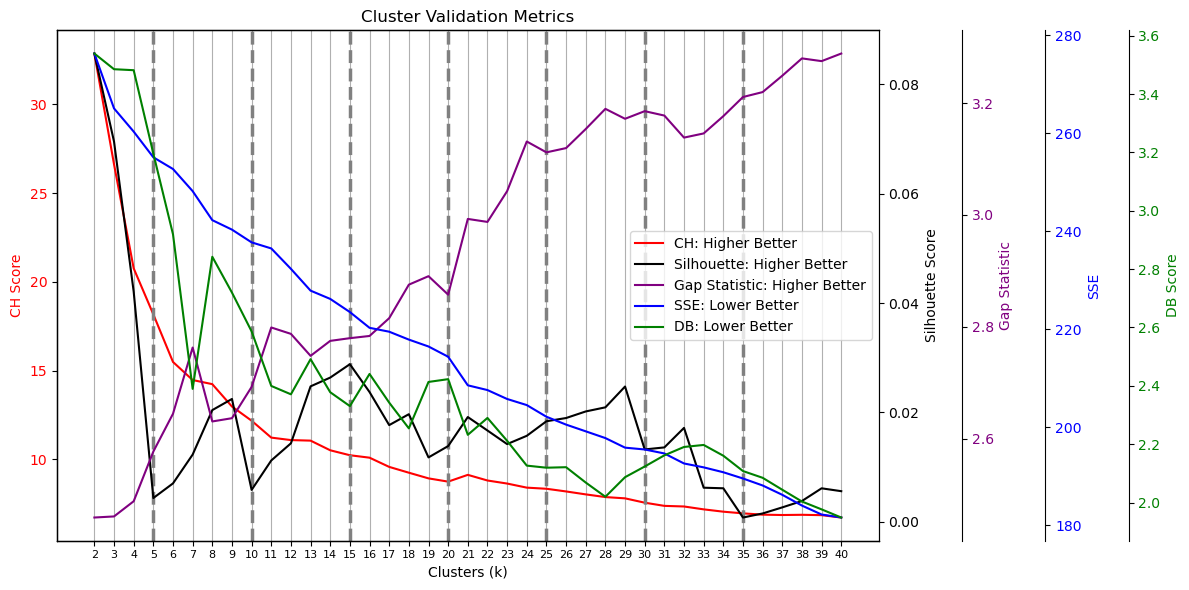

In [11]:
results_log_returns = cluster_range(X_unscaled.to_numpy(), KMeans(random_state=1234, n_init="auto"), 2, 40)
plot_internal_zoom_range(2, 40, results_log_returns)

While we see that k = 2 is the highest silhouette score, we want to explore more specific clusters that could challenge the DJI (30 stocks). Hence we look at clusters ideally around 20 or more. Based on this plot, k=20 could be a good candidate due to having the next best silhouette score at k >= 20.


In [12]:
results = kmeans_cluster(sp500_train.daily_log_returns, sp500_train.stock_sharpe, sp500_test, scale=False, k=20)
results['volatility'] = Portfolio(sp500_test.start_date, sp500_test.end_date, tickers=results['portfolio']).get_portf_volatility()
baseline.loc['Kmeans_20_unscaled'] = [results[i] for i in ['sharpe', 'sortino', 'return', 'volatility']]

results = kmeans_cluster(sp500_train.daily_log_returns, sp500_train.stock_sharpe, sp500_test, scale=False, k=2, top=15)
results['volatility'] = Portfolio(sp500_test.start_date, sp500_test.end_date, tickers=results['portfolio']).get_portf_volatility()
baseline.loc['Kmeans_2_unscaled'] = [results[i] for i in ['sharpe', 'sortino', 'return', 'volatility']]

baseline

Clustering Type        : KMeans
Clusters (preset)      : 20
Portfolio Sharpe Ratio : 0.1188
Silhouette Score       : 0.0176
Davies-Bouldin         : 2.4082
Calinski Harabasz      : 9.3993
Clustering Type        : KMeans
Clusters (preset)      : 2
Portfolio Sharpe Ratio : 0.1161
Silhouette Score       : 0.0857
Davies-Bouldin         : 3.5389
Calinski Harabasz      : 32.8676


,Sharpe,Sortino,Returns,Volatility
DJI,0.071854,0.116324,0.137407,0.007196
SP500,0.096611,0.150627,0.228182,0.008544
Random,0.082267,0.131013,0.215656,0.009320
Top30,0.122589,0.190844,0.264911,0.007699
Kmeans_30_unscaled,0.118351,0.175163,0.388573,0.011140
Kmeans_30_scaled,0.110255,0.160551,0.336451,0.010564
Kmeans_20_unscaled,0.118756,0.176903,0.420546,0.011871
Kmeans_2_unscaled,0.116146,0.183995,0.309634,0.009327


In [51]:
baseline.sort_values(by = 'Returns', ascending = False)

,Sharpe,Sortino,Returns
Kmeans_20_unscaled,0.118756,0.176903,0.420546
Kmeans_30_unscaled,0.118351,0.175163,0.388573
Kmeans_30_scaled,0.110255,0.160551,0.336451
Kmeans_2_unscaled,0.116146,0.183995,0.309634
Top30,0.122589,0.190844,0.264911
SP500,0.096611,0.150627,0.228182
Random,0.083160,0.132476,0.217859
DJI,0.071854,0.116324,0.137407


#### Scaled

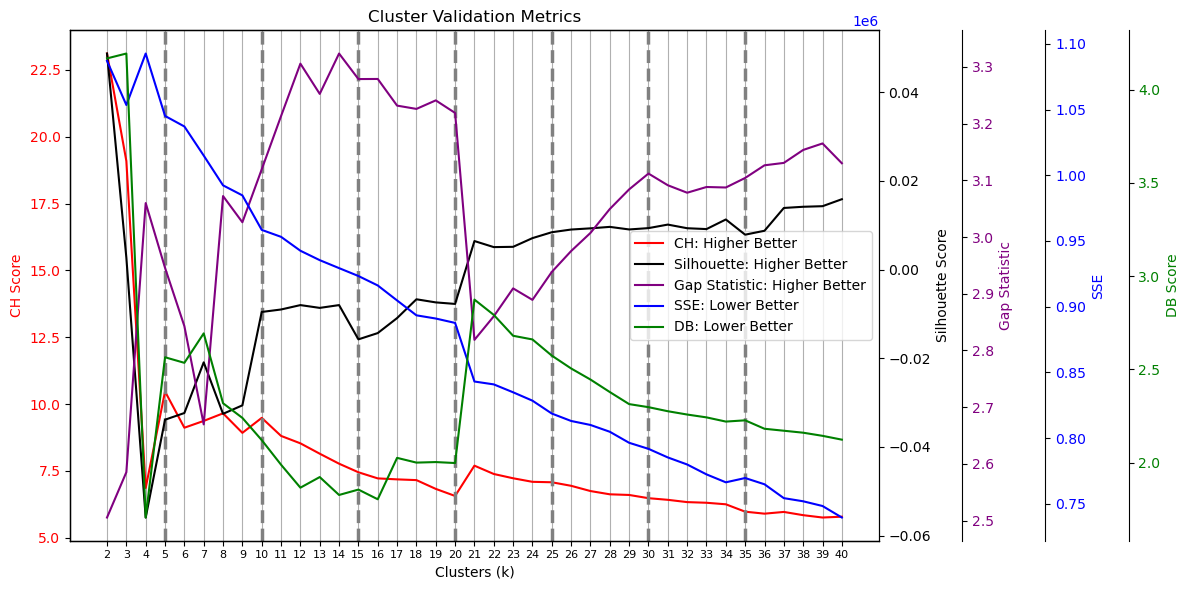

In [13]:
results_log_returns = cluster_range(X_scaled, KMeans(random_state=1234, n_init="auto"), 2, 40)
plot_internal_zoom_range(2, 40, results_log_returns)

While we see that k = 2 is the highest silhouette score, we want to explore more specific clusters that could challenge the DJI (30 stocks). Hence we look at clusters ideally around 20 or more. Based on this plot, k=19 could be a good candidate due to the following:
1. Silhouette Score: increased to around 0.45 at k=19 before decreasing
2. DB Score: already started decreasing after k = 18


In [14]:
results = kmeans_cluster(sp500_train.daily_log_returns, sp500_train.stock_sharpe, sp500_test, scale=True, k=21)
results['volatility'] = Portfolio(sp500_test.start_date, sp500_test.end_date, tickers=results['portfolio']).get_portf_volatility()
baseline.loc['Kmeans_21_scaled'] = [results[i] for i in ['sharpe', 'sortino', 'return', 'volatility']]

results = kmeans_cluster(sp500_train.daily_log_returns, sp500_train.stock_sharpe, sp500_test, scale=True, k=2, top=15)
results['volatility'] = Portfolio(sp500_test.start_date, sp500_test.end_date, tickers=results['portfolio']).get_portf_volatility()
baseline.loc['Kmeans_2_scaled'] = [results[i] for i in ['sharpe', 'sortino', 'return', 'volatility']]

baseline


Clustering Type        : KMeans
Clusters (preset)      : 21
Portfolio Sharpe Ratio : 0.0886
Silhouette Score       : 0.0006
Davies-Bouldin         : 2.1474
Calinski Harabasz      : 7.9407
Clustering Type        : KMeans
Clusters (preset)      : 2
Portfolio Sharpe Ratio : 0.1109
Silhouette Score       : 0.0781
Davies-Bouldin         : 4.1060
Calinski Harabasz      : 23.8306


,Sharpe,Sortino,Returns,Volatility
DJI,0.071854,0.116324,0.137407,0.007196
SP500,0.096611,0.150627,0.228182,0.008544
Random,0.082267,0.131013,0.215656,0.009320
Top30,0.122589,0.190844,0.264911,0.007699
Kmeans_30_unscaled,0.118351,0.175163,0.388573,0.011140
Kmeans_30_scaled,0.110255,0.160551,0.336451,0.010564
Kmeans_20_unscaled,0.118756,0.176903,0.420546,0.011871
Kmeans_2_unscaled,0.116146,0.183995,0.309634,0.009327
Kmeans_21_scaled,0.088583,0.126326,0.251295,0.010164
Kmeans_2_scaled,0.110867,0.178296,0.298968,0.009475


In [15]:
baseline.sort_values(by = 'Returns', ascending = False)

,Sharpe,Sortino,Returns,Volatility
Kmeans_20_unscaled,0.118756,0.176903,0.420546,0.011871
Kmeans_30_unscaled,0.118351,0.175163,0.388573,0.011140
Kmeans_30_scaled,0.110255,0.160551,0.336451,0.010564
Kmeans_2_unscaled,0.116146,0.183995,0.309634,0.009327
Kmeans_2_scaled,0.110867,0.178296,0.298968,0.009475
Top30,0.122589,0.190844,0.264911,0.007699
Kmeans_21_scaled,0.088583,0.126326,0.251295,0.010164
SP500,0.096611,0.150627,0.228182,0.008544
Random,0.082267,0.131013,0.215656,0.009320
DJI,0.071854,0.116324,0.137407,0.007196


### KMEdoids for 30 Clusters


#### Unscaled

In [16]:
results = kmedoids_cluster(sp500_train.daily_log_returns, sp500_train.stock_sharpe, sp500_test)
results['volatility'] = Portfolio(sp500_test.start_date, sp500_test.end_date, tickers=results['portfolio']).get_portf_volatility()
baseline.loc['Kmedoids_30_unscaled'] = [results[i] for i in ['sharpe', 'sortino', 'return', 'volatility']]

results = kmedoids_cluster(sp500_train.daily_log_returns, sp500_train.stock_sharpe, sp500_test, scale=True)
results['volatility'] = Portfolio(sp500_test.start_date, sp500_test.end_date, tickers=results['portfolio']).get_portf_volatility()
baseline.loc['Kmedoids_30_scaled'] = [results[i] for i in ['sharpe', 'sortino', 'return', 'volatility']]

baseline

Clustering Type        : KMedoids
Clusters (preset)      : 30
Portfolio Sharpe Ratio : 0.1242
Silhouette Score       : 0.0177
Davies-Bouldin         : 2.3136
Calinski Harabasz      : 8.2019
Clustering Type        : KMedoids
Clusters (preset)      : 30
Portfolio Sharpe Ratio : 0.1273
Silhouette Score       : 0.0229
Davies-Bouldin         : 2.1080
Calinski Harabasz      : 7.2903


,Sharpe,Sortino,Returns,Volatility
DJI,0.071854,0.116324,0.137407,0.007196
SP500,0.096611,0.150627,0.228182,0.008544
Random,0.082267,0.131013,0.215656,0.009320
Top30,0.122589,0.190844,0.264911,0.007699
Kmeans_30_unscaled,0.118351,0.175163,0.388573,0.011140
Kmeans_30_scaled,0.110255,0.160551,0.336451,0.010564
Kmeans_20_unscaled,0.118756,0.176903,0.420546,0.011871
Kmeans_2_unscaled,0.116146,0.183995,0.309634,0.009327
Kmeans_21_scaled,0.088583,0.126326,0.251295,0.010164
Kmeans_2_scaled,0.110867,0.178296,0.298968,0.009475


### KMedoids: Find optimal k-clusters

Search for best k (# of clusters) Unscaled Train: k=24 (0.130), k=35 (0.138)

#### Unscaled

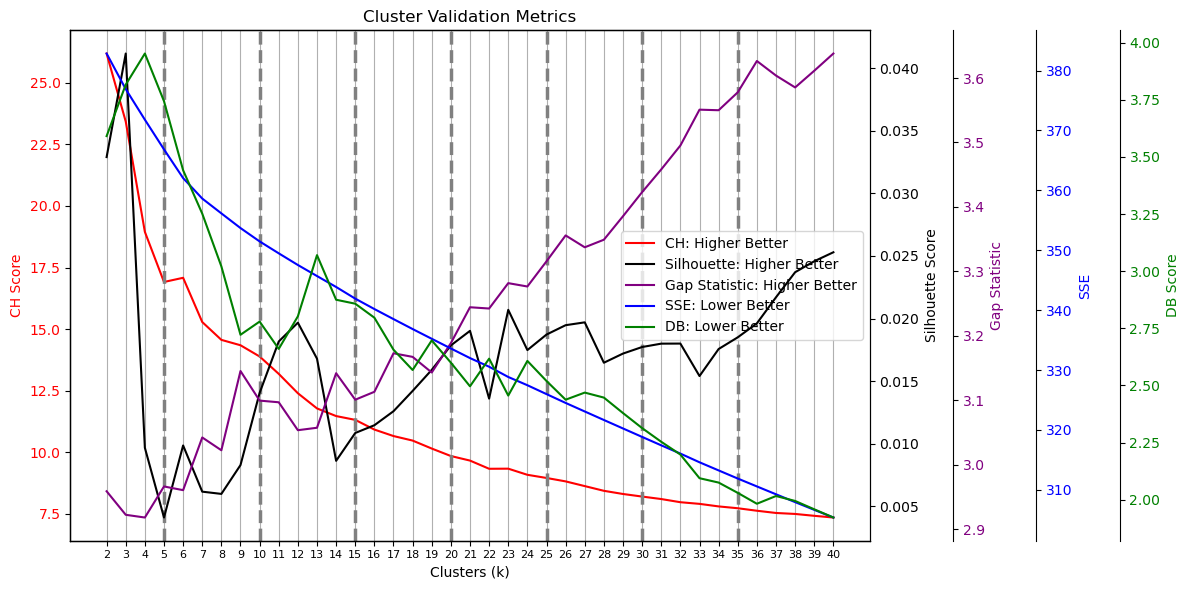

In [17]:
results_log_returns = cluster_range(X_unscaled.to_numpy(), KMedoids (random_state=1234, method="pam"), 2, 40)
plot_internal_zoom_range(2, 40, results_log_returns)

Based on new plot using unscaled train dataset, k=24 seems to be a good choice:  
1. Silhouette Coeff: before sharp decrease from k=24 to k=25/26
2. DB Score: before increase from k=24 to k=25

k=24 will result to 0.130 Sharpe ratio for the portfolio vs k=30 at 0.128

In [18]:
results = kmedoids_cluster(sp500_train.daily_log_returns, sp500_train.stock_sharpe, sp500_test, k=23)
results['volatility'] = Portfolio(sp500_test.start_date, sp500_test.end_date, tickers=results['portfolio']).get_portf_volatility()
baseline.loc['Kmedoids_23_unscaled'] = [results[i] for i in ['sharpe', 'sortino', 'return', 'volatility']]

results = kmedoids_cluster(sp500_train.daily_log_returns, sp500_train.stock_sharpe, sp500_test, k=3, top=10)
results['volatility'] = Portfolio(sp500_test.start_date, sp500_test.end_date, tickers=results['portfolio']).get_portf_volatility()
baseline.loc['Kmedoids_3_unscaled'] = [results[i] for i in ['sharpe', 'sortino', 'return', 'volatility']]

baseline


Clustering Type        : KMedoids
Clusters (preset)      : 23
Portfolio Sharpe Ratio : 0.1263
Silhouette Score       : 0.0207
Davies-Bouldin         : 2.4559
Calinski Harabasz      : 9.3343
Clustering Type        : KMedoids
Clusters (preset)      : 3
Portfolio Sharpe Ratio : 0.0838
Silhouette Score       : 0.0412
Davies-Bouldin         : 3.8162
Calinski Harabasz      : 23.4271


,Sharpe,Sortino,Returns,Volatility
DJI,0.071854,0.116324,0.137407,0.007196
SP500,0.096611,0.150627,0.228182,0.008544
Random,0.082267,0.131013,0.215656,0.009320
Top30,0.122589,0.190844,0.264911,0.007699
Kmeans_30_unscaled,0.118351,0.175163,0.388573,0.011140
Kmeans_30_scaled,0.110255,0.160551,0.336451,0.010564
Kmeans_20_unscaled,0.118756,0.176903,0.420546,0.011871
Kmeans_2_unscaled,0.116146,0.183995,0.309634,0.009327
Kmeans_21_scaled,0.088583,0.126326,0.251295,0.010164
Kmeans_2_scaled,0.110867,0.178296,0.298968,0.009475


#### Scaled

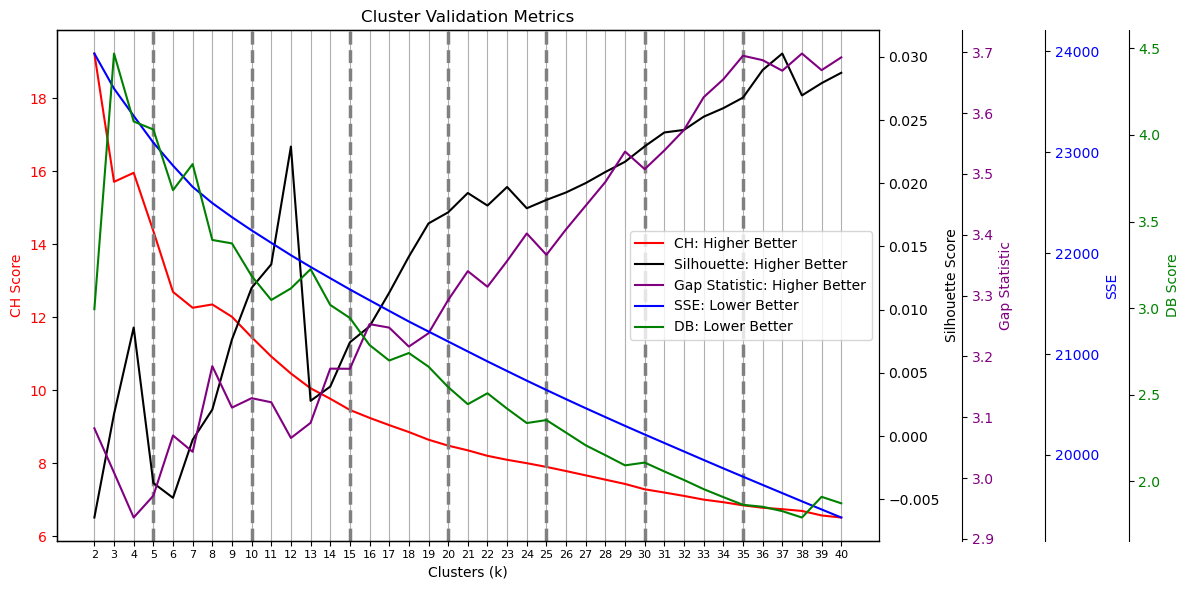

In [19]:
results_log_returns = cluster_range(X_scaled, KMedoids (random_state=1234, method="pam"), 2, 40)
plot_internal_zoom_range(2, 40, results_log_returns)

In [20]:
results = kmedoids_cluster(sp500_train.daily_log_returns, sp500_train.stock_sharpe, sp500_test, k=37, scale=True)
results['volatility'] = Portfolio(sp500_test.start_date, sp500_test.end_date, tickers=results['portfolio']).get_portf_volatility()
baseline.loc['Kmedoids_37_scaled'] = [results[i] for i in ['sharpe', 'sortino', 'return', 'volatility']]

results = kmedoids_cluster(sp500_train.daily_log_returns, sp500_train.stock_sharpe, sp500_test, k=12, top=2, scale=True)
results['volatility'] = Portfolio(sp500_test.start_date, sp500_test.end_date, tickers=results['portfolio']).get_portf_volatility()
baseline.loc['Kmedoids_12_scaled'] = [results[i] for i in ['sharpe', 'sortino', 'return', 'volatility']]

baseline

Clustering Type        : KMedoids
Clusters (preset)      : 37
Portfolio Sharpe Ratio : 0.1281
Silhouette Score       : 0.0303
Davies-Bouldin         : 1.8275
Calinski Harabasz      : 6.7464
Clustering Type        : KMedoids
Clusters (preset)      : 12
Portfolio Sharpe Ratio : 0.1153
Silhouette Score       : 0.0229
Davies-Bouldin         : 3.1137
Calinski Harabasz      : 10.4601


,Sharpe,Sortino,Returns,Volatility
DJI,0.071854,0.116324,0.137407,0.007196
SP500,0.096611,0.150627,0.228182,0.008544
Random,0.082267,0.131013,0.215656,0.009320
Top30,0.122589,0.190844,0.264911,0.007699
Kmeans_30_unscaled,0.118351,0.175163,0.388573,0.011140
Kmeans_30_scaled,0.110255,0.160551,0.336451,0.010564
Kmeans_20_unscaled,0.118756,0.176903,0.420546,0.011871
Kmeans_2_unscaled,0.116146,0.183995,0.309634,0.009327
Kmeans_21_scaled,0.088583,0.126326,0.251295,0.010164
Kmeans_2_scaled,0.110867,0.178296,0.298968,0.009475


## Hierarchical Clustering: Agglomerative (Get 30 clusters)

### Single Linkage

#### Unscaled

In [21]:
results = agglomerative_cluster(sp500_train.daily_log_returns, sp500_train.stock_sharpe, sp500_test, method='single')
results['volatility'] = Portfolio(sp500_test.start_date, sp500_test.end_date, tickers=results['portfolio']).get_portf_volatility()
baseline.loc['Agg_Single_30_unscaled'] = [results[i] for i in ['sharpe', 'sortino', 'return', 'volatility']]

results = agglomerative_cluster(sp500_train.daily_log_returns, sp500_train.stock_sharpe, sp500_test, method='single', scale=True)
results['volatility'] = Portfolio(sp500_test.start_date, sp500_test.end_date, tickers=results['portfolio']).get_portf_volatility()
baseline.loc['Agg_Single_30_scaled'] = [results[i] for i in ['sharpe', 'sortino', 'return', 'volatility']]

results = agglomerative_cluster(sp500_train.daily_log_returns, sp500_train.stock_sharpe, sp500_test, method='average')
results['volatility'] = Portfolio(sp500_test.start_date, sp500_test.end_date, tickers=results['portfolio']).get_portf_volatility()
baseline.loc['Agg_Avg_30_unscaled'] = [results[i] for i in ['sharpe', 'sortino', 'return', 'volatility']]

results = agglomerative_cluster(sp500_train.daily_log_returns, sp500_train.stock_sharpe, sp500_test, method='average', scale=True)
results['volatility'] = Portfolio(sp500_test.start_date, sp500_test.end_date, tickers=results['portfolio']).get_portf_volatility()
baseline.loc['Agg_Avg_30_scaled'] = [results[i] for i in ['sharpe', 'sortino', 'return', 'volatility']]

results = agglomerative_cluster(sp500_train.daily_log_returns, sp500_train.stock_sharpe, sp500_test, method='complete')
results['volatility'] = Portfolio(sp500_test.start_date, sp500_test.end_date, tickers=results['portfolio']).get_portf_volatility()
baseline.loc['Agg_Comp_30_unscaled'] = [results[i] for i in ['sharpe', 'sortino', 'return', 'volatility']]

results = agglomerative_cluster(sp500_train.daily_log_returns, sp500_train.stock_sharpe, sp500_test, method='complete', scale=True)
results['volatility'] = Portfolio(sp500_test.start_date, sp500_test.end_date, tickers=results['portfolio']).get_portf_volatility()
baseline.loc['Agg_Comp_30_scaled'] = [results[i] for i in ['sharpe', 'sortino', 'return', 'volatility']]

results = agglomerative_cluster(sp500_train.daily_log_returns, sp500_train.stock_sharpe, sp500_test, method='ward')
results['volatility'] = Portfolio(sp500_test.start_date, sp500_test.end_date, tickers=results['portfolio']).get_portf_volatility()
baseline.loc['Agg_Ward_30_unscaled'] = [results[i] for i in ['sharpe', 'sortino', 'return', 'volatility']]

results = agglomerative_cluster(sp500_train.daily_log_returns, sp500_train.stock_sharpe, sp500_test, method='ward', scale=True)
results['volatility'] = Portfolio(sp500_test.start_date, sp500_test.end_date, tickers=results['portfolio']).get_portf_volatility()
baseline.loc['Agg_Ward_30_scaled'] = [results[i] for i in ['sharpe', 'sortino', 'return', 'volatility']]

baseline

Linkage Method            : single
Preset Clusters           : 30
Sharpe Ratio of Portfolio : 0.1020
Silhouette Score       : 0.1660
Davies-Bouldin         : 0.5729
Calinski Harabasz      : 3.5169
Linkage Method            : single
Preset Clusters           : 30
Sharpe Ratio of Portfolio : 0.1050
Silhouette Score       : 0.1903
Davies-Bouldin         : 0.6101
Calinski Harabasz      : 3.5896
Linkage Method            : average
Preset Clusters           : 30
Sharpe Ratio of Portfolio : 0.0784
Silhouette Score       : 0.1911
Davies-Bouldin         : 0.7453
Calinski Harabasz      : 4.7251
Linkage Method            : average
Preset Clusters           : 30
Sharpe Ratio of Portfolio : 0.1160
Silhouette Score       : 0.2001
Davies-Bouldin         : 0.6788
Calinski Harabasz      : 4.0089
Linkage Method            : complete
Preset Clusters           : 30
Sharpe Ratio of Portfolio : 0.0992
Silhouette Score       : 0.0687
Davies-Bouldin         : 1.4338
Calinski Harabasz      : 7.0023
Linkage Met

,Sharpe,Sortino,Returns,Volatility
DJI,0.071854,0.116324,0.137407,0.007196
SP500,0.096611,0.150627,0.228182,0.008544
Random,0.082267,0.131013,0.215656,0.009320
Top30,0.122589,0.190844,0.264911,0.007699
Kmeans_30_unscaled,0.118351,0.175163,0.388573,0.011140
Kmeans_30_scaled,0.110255,0.160551,0.336451,0.010564
Kmeans_20_unscaled,0.118756,0.176903,0.420546,0.011871
Kmeans_2_unscaled,0.116146,0.183995,0.309634,0.009327
Kmeans_21_scaled,0.088583,0.126326,0.251295,0.010164
Kmeans_2_scaled,0.110867,0.178296,0.298968,0.009475


## Hierarchical Clustering: Agglomerative (Get Optimal K clusters)

---



### Unscaled

In [22]:
from sklearn.cluster import AgglomerativeClustering

def agglomerative_clustering(data, linkage):
    model = AgglomerativeClustering(linkage=linkage)
    labels = model.fit_predict(data)
    silhouette_avg = silhouette_score(data, labels)
    return labels, silhouette_avg

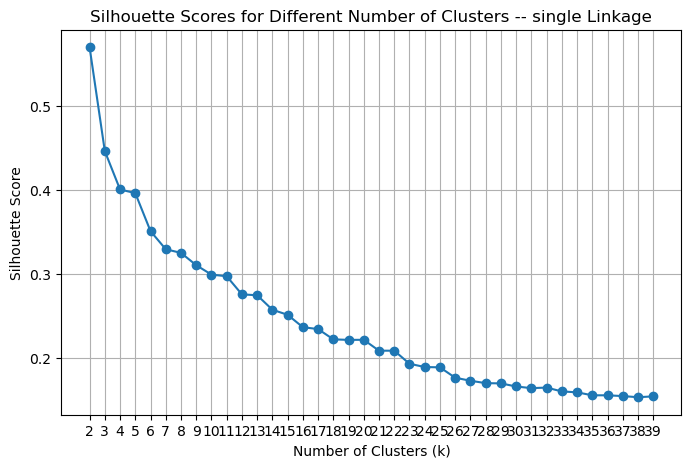

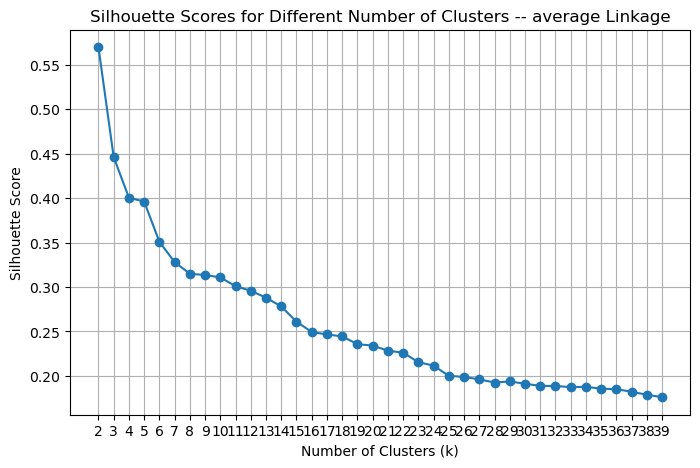

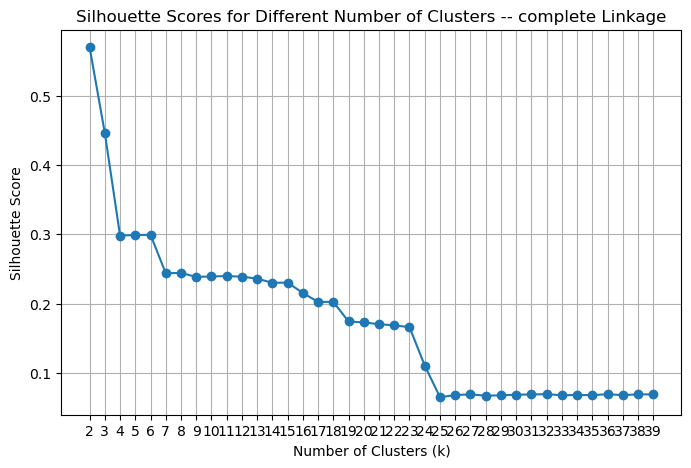

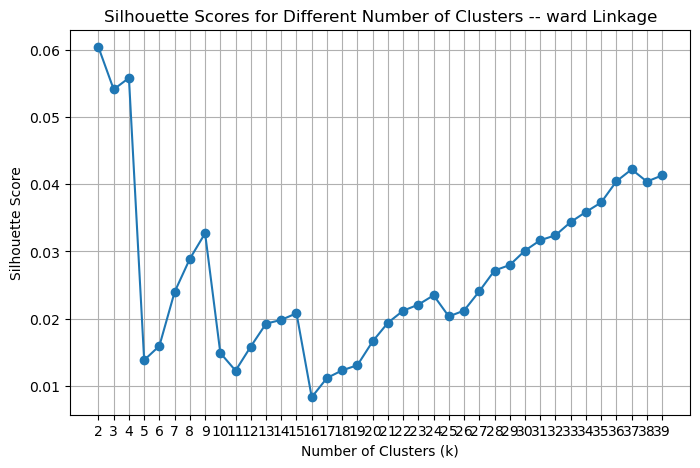

In [23]:
from sklearn.metrics import silhouette_score
linkage_methods = ['single', 'average', 'complete', 'ward']

for link in linkage_methods:
    scores = []
    for k in range(2, 40):
        agg = AgglomerativeClustering(n_clusters=k, linkage=link)
        y_pred = agg.fit_predict(X_unscaled)
        score = silhouette_score(X_unscaled, y_pred)
        scores.append(score)

    plt.figure(figsize=(8, 5))
    plt.plot(range(2,40), scores, marker='o')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.title(f'Silhouette Scores for Different Number of Clusters -- {link} Linkage')
    plt.xticks(range(2,40))
    plt.grid(True)
    plt.show()

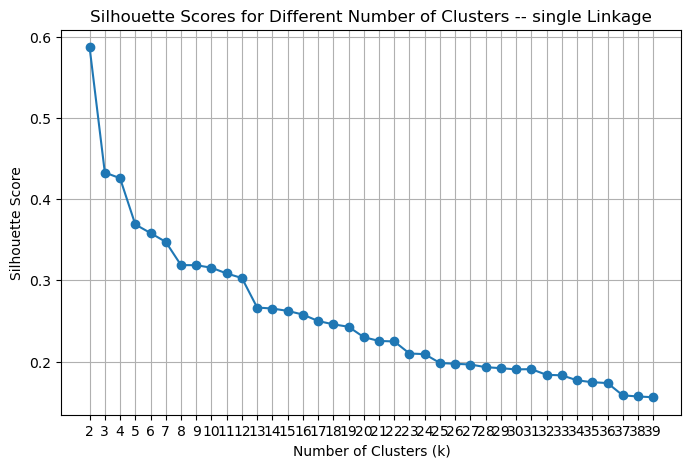

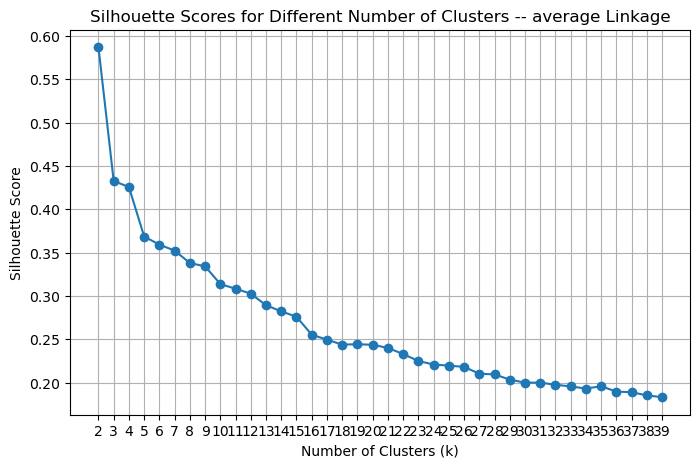

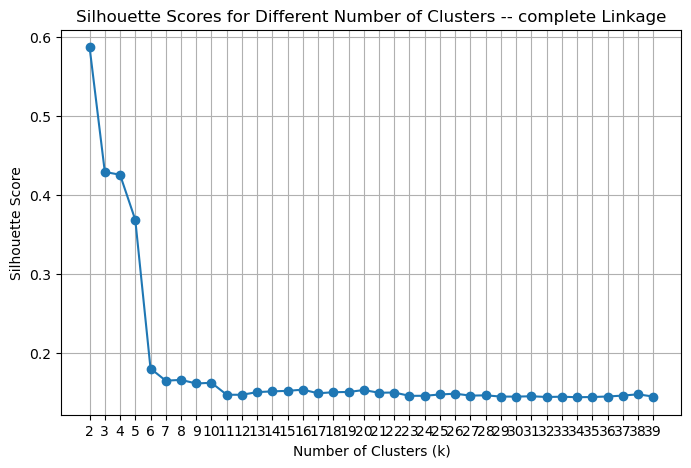

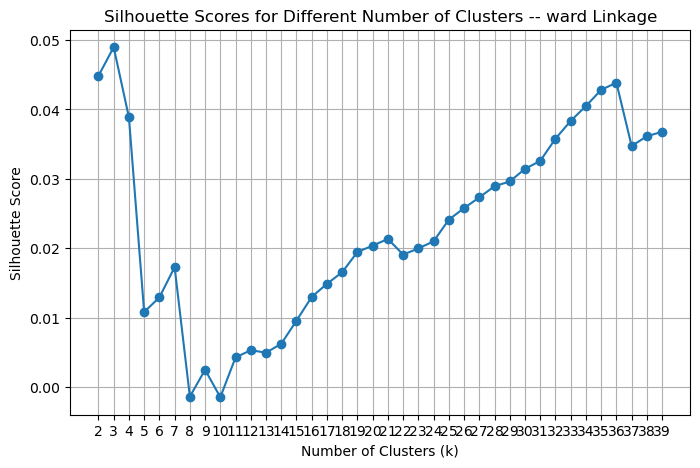

In [24]:
from sklearn.metrics import silhouette_score
linkage_methods = ['single', 'average', 'complete', 'ward']

for link in linkage_methods:
    scores = []
    for k in range(2, 40):
        agg = AgglomerativeClustering(n_clusters=k, linkage=link)
        y_pred = agg.fit_predict(X_scaled)
        score = silhouette_score(X_scaled, y_pred)
        scores.append(score)

    plt.figure(figsize=(8, 5))
    plt.plot(range(2,40), scores, marker='o')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.title(f'Silhouette Scores for Different Number of Clusters -- {link} Linkage')
    plt.xticks(range(2,40))
    plt.grid(True)
    plt.show()

In [25]:
results = agglomerative_cluster(sp500_train.daily_log_returns, sp500_train.stock_sharpe, sp500_test, method='single', k=24)
results['volatility'] = Portfolio(sp500_test.start_date, sp500_test.end_date, tickers=results['portfolio']).get_portf_volatility()
baseline.loc['Agg_Single_24_unscaled'] = [results[i] for i in ['sharpe', 'sortino', 'return', 'volatility']]

results = agglomerative_cluster(sp500_train.daily_log_returns, sp500_train.stock_sharpe, sp500_test, method='average', k=28)
results['volatility'] = Portfolio(sp500_test.start_date, sp500_test.end_date, tickers=results['portfolio']).get_portf_volatility()
baseline.loc['Agg_Avg_28_unscaled'] = [results[i] for i in ['sharpe', 'sortino', 'return', 'volatility']]

results = agglomerative_cluster(sp500_train.daily_log_returns, sp500_train.stock_sharpe, sp500_test, method='complete', k=10, top=3)
results['volatility'] = Portfolio(sp500_test.start_date, sp500_test.end_date, tickers=results['portfolio']).get_portf_volatility()
baseline.loc['Agg_Comp_10_unscaled'] = [results[i] for i in ['sharpe', 'sortino', 'return', 'volatility']]

results = agglomerative_cluster(sp500_train.daily_log_returns, sp500_train.stock_sharpe, sp500_test, method='ward', k=36)
results['volatility'] = Portfolio(sp500_test.start_date, sp500_test.end_date, tickers=results['portfolio']).get_portf_volatility()
baseline.loc['Agg_Ward_36_unscaled'] = [results[i] for i in ['sharpe', 'sortino', 'return', 'volatility']]

baseline

Linkage Method            : single
Preset Clusters           : 24
Sharpe Ratio of Portfolio : 0.0921
Silhouette Score       : 0.1891
Davies-Bouldin         : 0.5661
Calinski Harabasz      : 3.6726
Linkage Method            : average
Preset Clusters           : 28
Sharpe Ratio of Portfolio : 0.0737
Silhouette Score       : 0.1925
Davies-Bouldin         : 0.7187
Calinski Harabasz      : 4.7657
Linkage Method            : complete
Preset Clusters           : 10
Sharpe Ratio of Portfolio : 0.0921
Silhouette Score       : 0.2392
Davies-Bouldin         : 1.2924
Calinski Harabasz      : 7.8249
Linkage Method            : ward
Preset Clusters           : 36
Sharpe Ratio of Portfolio : 0.1358
Silhouette Score       : 0.0404
Davies-Bouldin         : 1.9309
Calinski Harabasz      : 8.1811


,Sharpe,Sortino,Returns,Volatility
DJI,0.071854,0.116324,0.137407,0.007196
SP500,0.096611,0.150627,0.228182,0.008544
Random,0.082267,0.131013,0.215656,0.009320
Top30,0.122589,0.190844,0.264911,0.007699
Kmeans_30_unscaled,0.118351,0.175163,0.388573,0.011140
Kmeans_30_scaled,0.110255,0.160551,0.336451,0.010564
Kmeans_20_unscaled,0.118756,0.176903,0.420546,0.011871
Kmeans_2_unscaled,0.116146,0.183995,0.309634,0.009327
Kmeans_21_scaled,0.088583,0.126326,0.251295,0.010164
Kmeans_2_scaled,0.110867,0.178296,0.298968,0.009475


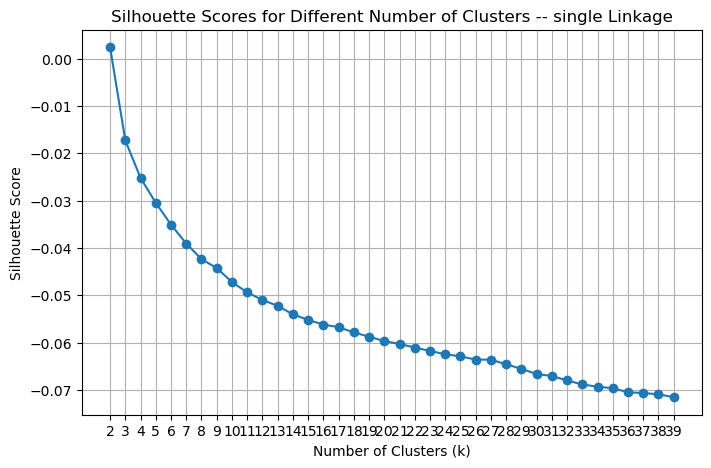

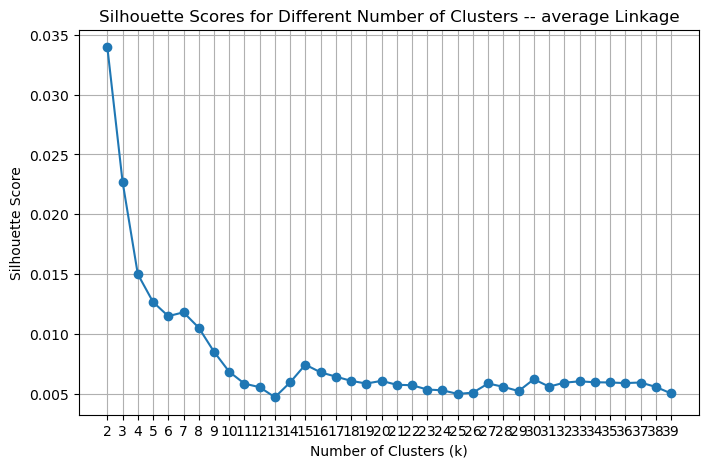

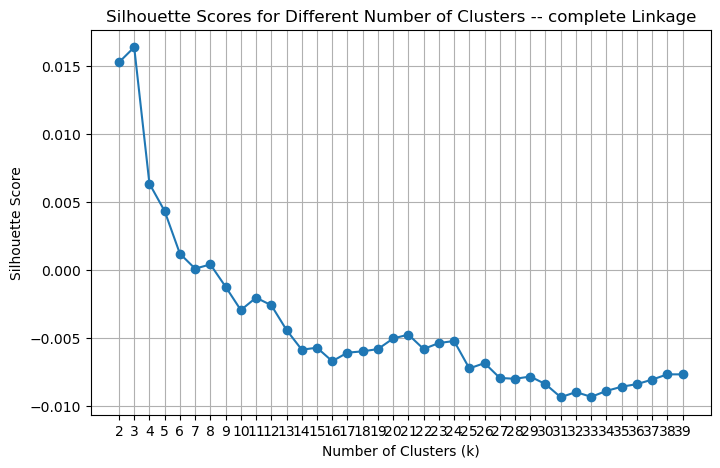

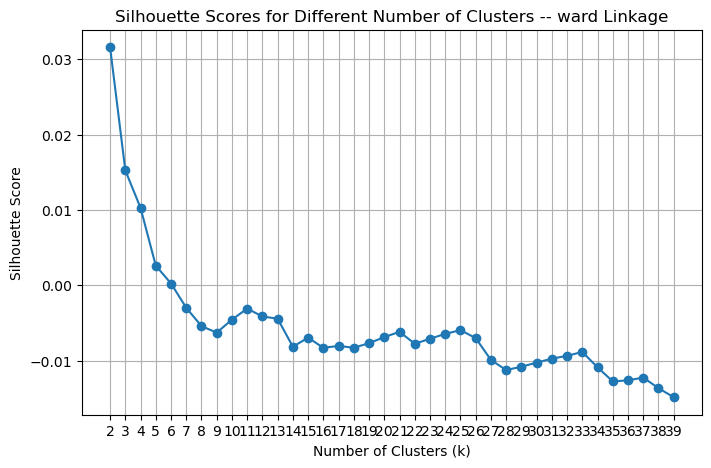

In [27]:
X = X_scaled.transpose()
from sklearn.metrics import silhouette_score
linkage_methods = ['single', 'average', 'complete', 'ward']

for link in linkage_methods:
    scores = []
    for k in range(2, 40):
        agg = AgglomerativeClustering(n_clusters=k, linkage=link)
        y_pred = agg.fit_predict(X)
        score = silhouette_score(X, y_pred)
        scores.append(score)

    plt.figure(figsize=(8, 5))
    plt.plot(range(2,40), scores, marker='o')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.title(f'Silhouette Scores for Different Number of Clusters -- {link} Linkage')
    plt.xticks(range(2,40))
    plt.grid(True)
    plt.show()

In [28]:
results = agglomerative_cluster(sp500_train.daily_log_returns, sp500_train.stock_sharpe, sp500_test, method='single', scale=True, k=21)
results['volatility'] = Portfolio(sp500_test.start_date, sp500_test.end_date, tickers=results['portfolio']).get_portf_volatility()
baseline.loc['Agg_Single_21_scaled'] = [results[i] for i in ['sharpe', 'sortino', 'return', 'volatility']]

results = agglomerative_cluster(sp500_train.daily_log_returns, sp500_train.stock_sharpe, sp500_test, method='average', scale=True, k=27)
results['volatility'] = Portfolio(sp500_test.start_date, sp500_test.end_date, tickers=results['portfolio']).get_portf_volatility()
baseline.loc['Agg_Avg_27_scaled'] = [results[i] for i in ['sharpe', 'sortino', 'return', 'volatility']]

results = agglomerative_cluster(sp500_train.daily_log_returns, sp500_train.stock_sharpe, sp500_test, method='complete', scale=True, k=37)
results['volatility'] = Portfolio(sp500_test.start_date, sp500_test.end_date, tickers=results['portfolio']).get_portf_volatility()
baseline.loc['Agg_Comp_37_scaled'] = [results[i] for i in ['sharpe', 'sortino', 'return', 'volatility']]

results = agglomerative_cluster(sp500_train.daily_log_returns, sp500_train.stock_sharpe, sp500_test, method='ward', scale=True, k=28)
results['volatility'] = Portfolio(sp500_test.start_date, sp500_test.end_date, tickers=results['portfolio']).get_portf_volatility()
baseline.loc['Agg_Ward_28_scaled'] = [results[i] for i in ['sharpe', 'sortino', 'return', 'volatility']]

baseline

Linkage Method            : single
Preset Clusters           : 21
Sharpe Ratio of Portfolio : 0.1186
Silhouette Score       : 0.2253
Davies-Bouldin         : 0.5239
Calinski Harabasz      : 3.8178
Linkage Method            : average
Preset Clusters           : 27
Sharpe Ratio of Portfolio : 0.1252
Silhouette Score       : 0.2104
Davies-Bouldin         : 0.6235
Calinski Harabasz      : 4.0566
Linkage Method            : complete
Preset Clusters           : 37
Sharpe Ratio of Portfolio : 0.1431
Silhouette Score       : 0.1464
Davies-Bouldin         : 1.2888
Calinski Harabasz      : 5.0420
Linkage Method            : ward
Preset Clusters           : 28
Sharpe Ratio of Portfolio : 0.1244
Silhouette Score       : 0.0289
Davies-Bouldin         : 2.0860
Calinski Harabasz      : 8.0481


,Sharpe,Sortino,Returns,Volatility
DJI,0.071854,0.116324,0.137407,0.007196
SP500,0.096611,0.150627,0.228182,0.008544
Random,0.082267,0.131013,0.215656,0.009320
Top30,0.122589,0.190844,0.264911,0.007699
Kmeans_30_unscaled,0.118351,0.175163,0.388573,0.011140
Kmeans_30_scaled,0.110255,0.160551,0.336451,0.010564
Kmeans_20_unscaled,0.118756,0.176903,0.420546,0.011871
Kmeans_2_unscaled,0.116146,0.183995,0.309634,0.009327
Kmeans_21_scaled,0.088583,0.126326,0.251295,0.010164
Kmeans_2_scaled,0.110867,0.178296,0.298968,0.009475


In [29]:
baseline.sort_values(by = 'Returns', ascending = False)

,Sharpe,Sortino,Returns,Volatility
Agg_Comp_30_scaled,0.142578,0.243412,0.502988,0.011477
Agg_Comp_37_scaled,0.143050,0.244449,0.487897,0.011156
Agg_Single_21_scaled,0.118597,0.185120,0.459488,0.012803
Agg_Avg_27_scaled,0.125247,0.199332,0.435343,0.011588
Kmedoids_23_unscaled,0.126310,0.186537,0.425505,0.011272
Kmeans_20_unscaled,0.118756,0.176903,0.420546,0.011871
Kmedoids_30_scaled,0.127338,0.190906,0.413246,0.010909
Kmedoids_37_scaled,0.128103,0.194179,0.409933,0.010770
Agg_Ward_36_unscaled,0.135780,0.200031,0.407204,0.010104
Kmedoids_30_unscaled,0.124225,0.182423,0.406523,0.011028


In [30]:
baseline.sort_values(by = 'Sharpe', ascending = False)

,Sharpe,Sortino,Returns,Volatility
Agg_Comp_37_scaled,0.143050,0.244449,0.487897,0.011156
Agg_Comp_30_scaled,0.142578,0.243412,0.502988,0.011477
Agg_Ward_36_unscaled,0.135780,0.200031,0.407204,0.010104
Agg_Ward_30_scaled,0.133455,0.194301,0.406057,0.010255
Agg_Ward_30_unscaled,0.129109,0.186831,0.395011,0.010355
Kmedoids_37_scaled,0.128103,0.194179,0.409933,0.010770
Kmedoids_30_scaled,0.127338,0.190906,0.413246,0.010909
Kmedoids_23_unscaled,0.126310,0.186537,0.425505,0.011272
Agg_Avg_27_scaled,0.125247,0.199332,0.435343,0.011588
Agg_Ward_28_scaled,0.124386,0.184965,0.385640,0.010531
